<a href="https://colab.research.google.com/github/claredavies/AutomaticLearning/blob/main/Image3DFaceSubstitution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/bmalcover/image3D.git

fatal: destination path 'image3D' already exists and is not an empty directory.


# Face substitution
Face substitution the project that we are going to develop this week.

**Exercise:**
The main idea behind this little practice is to learn how we can apply the Viola Jones face detector and at the same time practice with simple image operations. It can be done following next two steps:

**First:** we are going to follow the next tutorial (link) that shows how to apply the detector on a video stream. If you don't have a webcam, you can download a video. It is important to understand the code you are copying.

**Second:** we are going to overlap a superhero mask to the biggest face detected at each frame. In the folder images you can find some examples.

# Video Stream from webcam

In [9]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import html
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
from google.colab.patches import cv2_imshow

In [10]:
def jsob_to_image(js_object):
  # decode base64 image
  image_bytes = b64decode(js_object.split(',')[1])
  # convert bytes to numpy array
  img_array = np.frombuffer(image_bytes, dtype=np.uint8)
  # convert numpy array into OpenCV BGR 
  frame = cv2.imdecode(img_array, flags=1)

  return frame

In [11]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="blue: red; font-weight: bold;">' +
          'click here to stop the video</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; 
      captureCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame() {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
  
            
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame():
  data = eval_js('stream_frame()')
  return data

In [12]:
def resize_image(image, scale_percent):
  # scale_percent = 220 # percent of original size
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized_image

# Face detection

In [13]:
import os
cascPathface = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
cascPatheyes = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_eye_tree_eyeglasses.xml"

In [14]:
faceCascade = cv2.CascadeClassifier(cascPathface)
eyeCascade = cv2.CascadeClassifier(cascPatheyes)

<IPython.core.display.Javascript object>

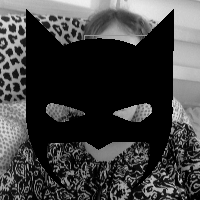

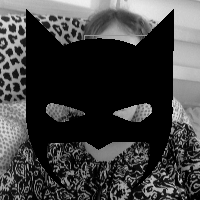

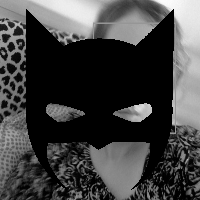

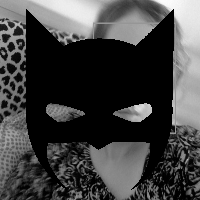

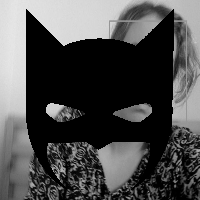

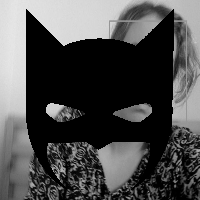

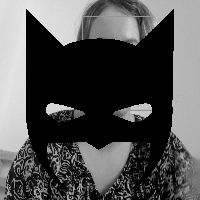

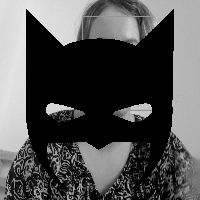

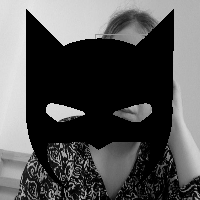

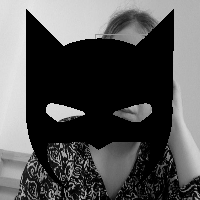

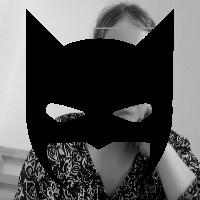

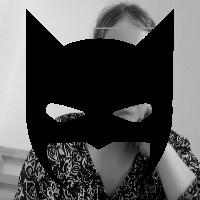

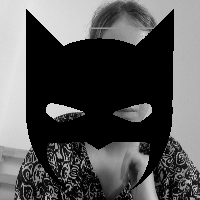

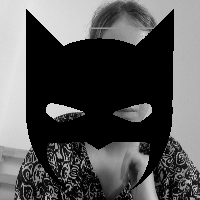

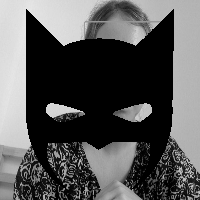

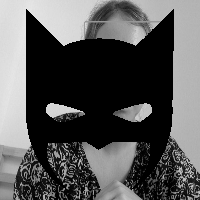

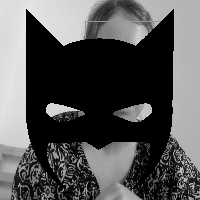

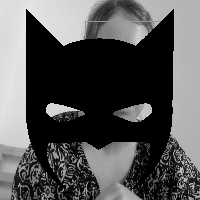

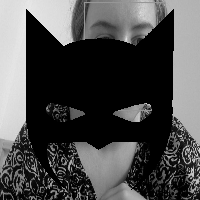

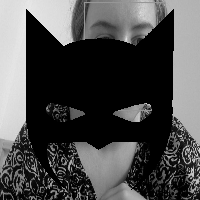

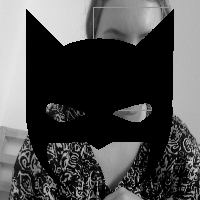

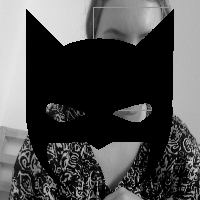

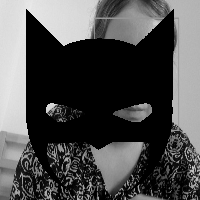

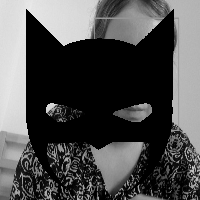

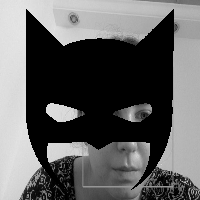

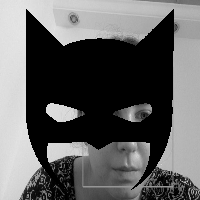

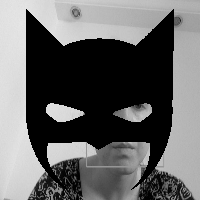

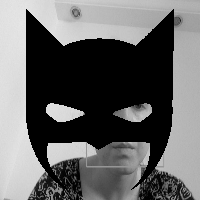

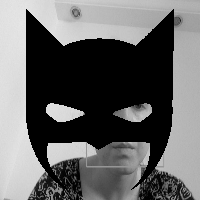

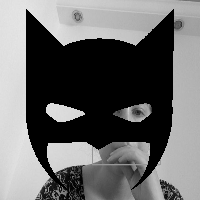

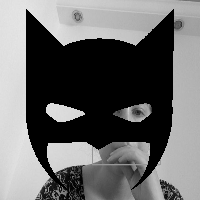

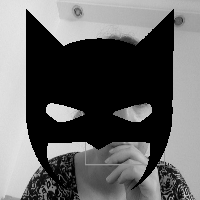

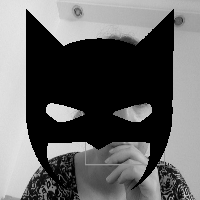

KeyboardInterrupt: ignored

In [79]:
video_stream()

while True:
    frame_js = video_frame()
    if not frame_js:
        break
    img = jsob_to_image(frame_js["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h),(0,255,0), 2)
        faceROI = img[y:y+h,x:x+w]
        eyes = eyeCascade.detectMultiScale(faceROI)
        for (x2, y2, w2, h2) in eyes:
            eye_center = (x + x2 + w2 // 2, y + y2 + h2 // 2)
            radius = int(round((w2 + h2) * 0.25))
            # img1 = cv2.circle(img, eye_center, radius, (255, 0, 0), 4)
            back = img
            back = cv2.cvtColor(back,cv2.COLOR_BGR2GRAY)
            back = cv2.resize(back, dsize=(200, 200)) 

            # load resized image as grayscale
            template = cv2.imread("image3D/FaceSubstitution/images/im_batman.png", cv2.IMREAD_GRAYSCALE)
            template = cv2.resize(template, dsize=(200, 200)) 

            dst = cv2.addWeighted(template,0.7,back,0.3,0)

            result = cv2.bitwise_and(back,back,mask = template)
            cv2_imshow(result)